In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.math.log(10000.0) / d_model))
        print(position * div_term)
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        pe = pe.permute(1,0,2)
        self.register_buffer('pe', pe)
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """ 
        print(x.shape, self.pe.shape)
        x = x + self.pe[:, :x.size(0)]
        
        return self.dropout(x)

In [61]:

# Pytorch's   positional encoding implementaiton
class DualPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 512, max_thought_len: int = 4):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_embed = d_model

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)


        self.register_buffer('pe', pe)
        self.max_len, self.max_thought_len = max_len, max_thought_len
        self.thought_position_encoding = nn.Embedding(max_thought_len+1, self.d_embed)

    def forward(self, x: torch.Tensor, thoughts_taken: int, real_token_count: int) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        batch_size = x.size(0)
        thoughts_taken = thoughts_taken + 1

        # Reshape to put thoughts per token taken on the same dimension
        x = x[:,:real_token_count * thoughts_taken,:].view(batch_size,real_token_count, thoughts_taken, self.d_embed)
        # Add both kinds of embeddings
        x = x + self.pe[:,:real_token_count].unsqueeze(2)
        x = x + self.thought_position_encoding(torch.arange(thoughts_taken)).unsqueeze(0).unsqueeze(0)

        # Reshape and pad back to original size
        x = x.view(batch_size, -1, self.d_embed)

        padding_size = self.max_len - (real_token_count * thoughts_taken)
        if padding_size > 0:
            x = F.pad(x, (0, 0, 0, padding_size), mode='constant', value=0)

        return self.dropout(x)

In [67]:
m = 20
b = DualPositionalEncoding(d_model=m,dropout=0)
l = torch.zeros(1,300,m) 



In [79]:
print(b(l,0,100).detach().numpy()[0][1])

[ 1.0082601  -0.9984897   0.36287698 -0.9473115  -0.39015624 -0.22015
 -0.08961502  1.2306099  -1.4858717   1.2780106   3.1331654   0.98882765
  0.93513715 -0.79501885  0.6948013   0.97684973 -1.4157237  -1.2051105
  0.16627705  1.5935832 ]


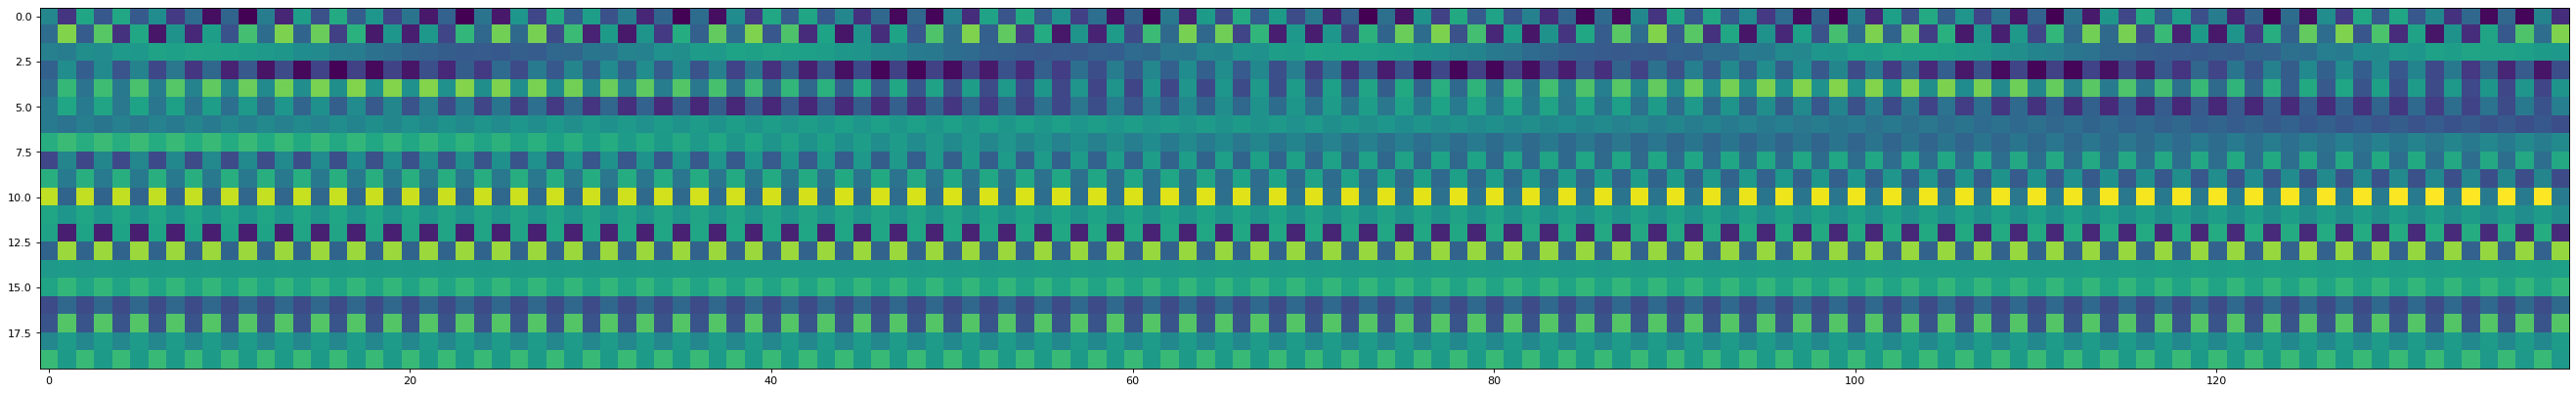

In [71]:

plt.figure(figsize=(80, 6), dpi=80)

plt.imshow(b(l,1,100).detach().numpy().squeeze()[0:140].T)

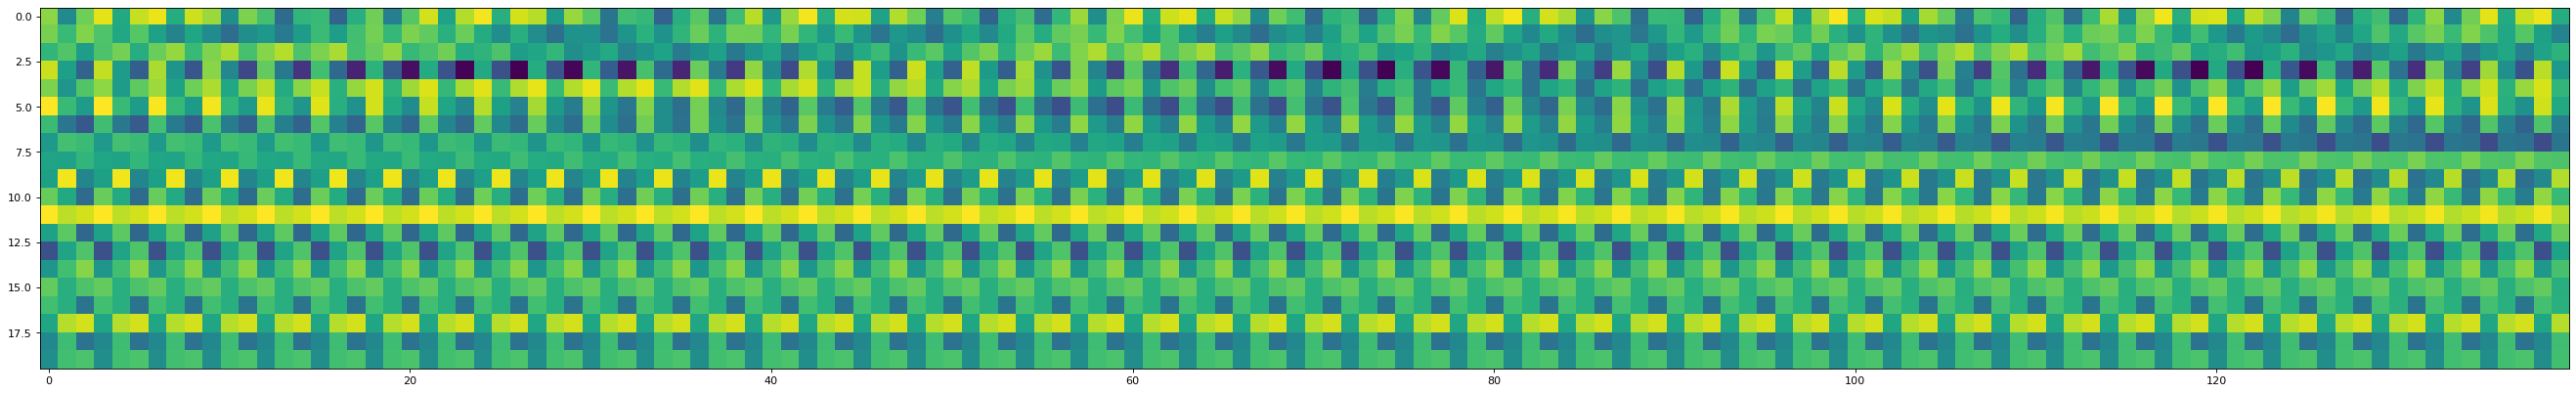

In [50]:
m = 20
b = DualPositionalEncoding(d_model=m,dropout=0)
l = torch.ones(1,300,m) 


plt.figure(figsize=(80, 6), dpi=80)

plt.imshow(b(l,2,50).detach().numpy().squeeze()[0:140].T)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 3.9811e-01, 1.5849e-01,  ..., 1.5849e-03, 6.3096e-04,
         2.5119e-04],
        [2.0000e+00, 7.9621e-01, 3.1698e-01,  ..., 3.1698e-03, 1.2619e-03,
         5.0238e-04],
        ...,
        [5.0900e+02, 2.0264e+02, 8.0671e+01,  ..., 8.0671e-01, 3.2116e-01,
         1.2785e-01],
        [5.1000e+02, 2.0303e+02, 8.0830e+01,  ..., 8.0830e-01, 3.2179e-01,
         1.2811e-01],
        [5.1100e+02, 2.0343e+02, 8.0988e+01,  ..., 8.0988e-01, 3.2242e-01,
         1.2836e-01]])
torch.Size([1, 60, 20]) torch.Size([1, 512, 20])


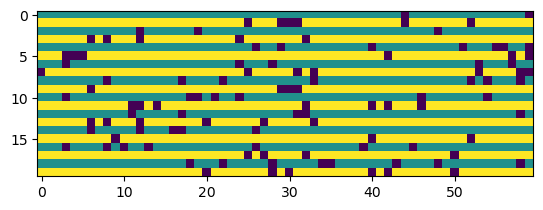

In [15]:
m = 20
b = PositionalEncoding(d_model=m)
l = torch.ones(1,60,m) 

plt.imshow(b(l).squeeze().T)

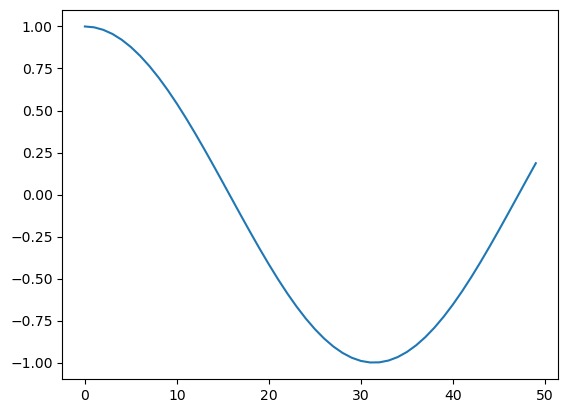

In [61]:
plt.plot(pe[:, 5].detach().numpy(), label=f'Dimension {i + 1}')

In [54]:
max_len = 50
d_model = 10

positional_encoding = PositionalEncoding(d_model=d_model, dropout=0, max_len= max_len)
embed = torch.ones(1,max_len, d_model) * torch.arange(0,d_model).view(1,-1)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04],
        [2.0000e+00, 3.1698e-01, 5.0238e-02, 7.9621e-03, 1.2619e-03],
        [3.0000e+00, 4.7547e-01, 7.5357e-02, 1.1943e-02, 1.8929e-03],
        [4.0000e+00, 6.3396e-01, 1.0048e-01, 1.5924e-02, 2.5238e-03],
        [5.0000e+00, 7.9245e-01, 1.2559e-01, 1.9905e-02, 3.1548e-03],
        [6.0000e+00, 9.5094e-01, 1.5071e-01, 2.3886e-02, 3.7857e-03],
        [7.0000e+00, 1.1094e+00, 1.7583e-01, 2.7868e-02, 4.4167e-03],
        [8.0000e+00, 1.2679e+00, 2.0095e-01, 3.1849e-02, 5.0477e-03],
        [9.0000e+00, 1.4264e+00, 2.2607e-01, 3.5830e-02, 5.6786e-03],
        [1.0000e+01, 1.5849e+00, 2.5119e-01, 3.9811e-02, 6.3096e-03],
        [1.1000e+01, 1.7434e+00, 2.7631e-01, 4.3792e-02, 6.9405e-03],
        [1.2000e+01, 1.9019e+00, 3.0143e-01, 4.7773e-02, 7.5715e-03],
        [1.3000e+01, 2.0604e+00, 3.2655e-01, 5.1754e-02, 8.2024e-03],
        [1.4000e+01,

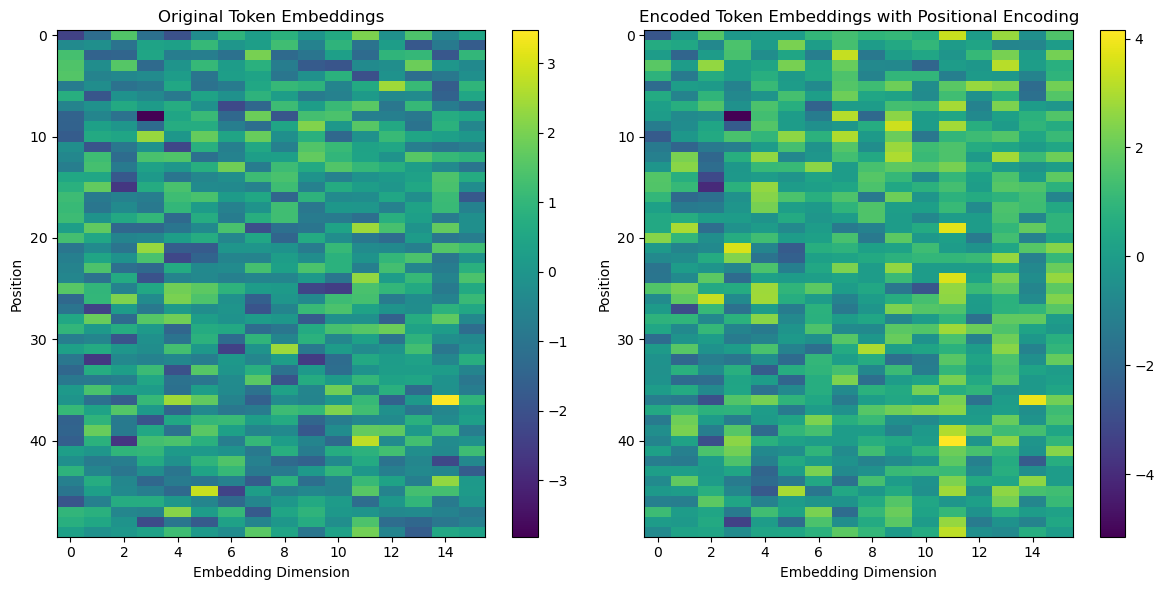

In [58]:
import torch
import matplotlib.pyplot as plt

# Define the PositionalEncoding class as you provided
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
d_model = 16  # Dimension of the embedding
seq_len = 50  # Length of the sequence
batch_size = 1  # For simplicity, we'll use a single batch

# Create random embeddings for the sequence
token_embeddings = torch.randn(seq_len, batch_size, d_model)

# Initialize the Positional Encoding
positional_encoding = PositionalEncoding(d_model=d_model)

# Apply positional encoding
encoded_embeddings = positional_encoding(token_embeddings)

# Plotting
plt.figure(figsize=(12, 6))

# Plot original token embeddings
plt.subplot(1, 2, 1)
plt.title('Original Token Embeddings')
plt.imshow(token_embeddings.squeeze(1).detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')

# Plot encoded embeddings
plt.subplot(1, 2, 2)
plt.title('Encoded Token Embeddings with Positional Encoding')
plt.imshow(encoded_embeddings.squeeze(1).detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')

plt.tight_layout()
plt.show()


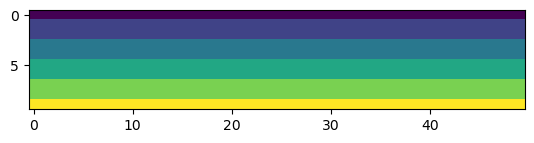

In [56]:
plt.imshow(positional_encoding(embed).squeeze().T)

In [72]:
torch.arange(1)

tensor([0])